## This program is made to track the rigid body variablity across the experimental protocol

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')

# Set the save game location
# Must have format of "../PointerExperimentData/Name_dd_mm__hh_mm_metadata" with no file extension
# saveFile = "../PointerExperimentData/Ashwin_13_02"
# saveGameLocation = saveFile + "/Ash_13_02_13_19" # must have format of "Name_dd_mm__hh_mm_metadata" with no file extension

from Experiment_pointer.runFullExperiment import saveDirectory, saveGameLocation

saveFile = saveDirectory

# Replace Experiment pointer with .. as notebook runs from another directory
saveFile = saveFile.replace("Experiment_pointer","..")
saveGameLocation = saveGameLocation.replace("Experiment_pointer","..")
path = "/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis"
os.chdir(path)

from Experiment_pointer.experimentFunctions import processTrialData
DOFOffset = 0.03
from sklearn.decomposition import PCA
from lib_streamAndRenderDataWorkflows.config_streaming import bodyParts


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Fetch all trial information


rigidBodies1, cursorPos1,cursorVel1,goCues1,targetHits1,timeStamps1, minDof1,maxDof1,d,targetFailedAppearTimes1 = processTrialData(saveGameLocation + "_training1",DOFOffset)
rigidBodies2, cursorPos2,cursorVel2,goCues2,targetHits2,timeStamps2, minDof2,maxDof2,e,targetFailedAppearTimes2 = processTrialData(saveGameLocation + "_training2",DOFOffset)
rigidBodies3, cursorPos3,cursorVel3,goCues3,targetHits3,timeStamps3, minDof3,maxDof3,f,targetFailedAppearTimes3 = processTrialData(saveGameLocation + "_training3",DOFOffset)
rigidBodies4, cursorPos4,cursorVel4,goCues4,targetHits4,timeStamps4, minDof4,maxDof4,g,targetFailedAppearTimes4 = processTrialData(saveGameLocation + "_training4",DOFOffset)
rigidBodies5, cursorPos5,cursorVel5,goCues5,targetHits5,timeStamps5, minDof5,maxDof5,h,targetFailedAppearTimes5 = processTrialData(saveGameLocation + "_test",DOFOffset)# make this test 

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


In [3]:


def extractPCAFromRigidBodies(rigidBodyVector,cursorPos,useCursor = None):
    """
    Function that performs pca on each rigid body in rigid body vector to extract out main variations of each rigid body during trial
    """
    dimensionalityReducedRigidBodyVector = np.zeros((rigidBodyVector.shape[0],38))
    for rigidBodyIdx in range(0,19):

        
        # Retrieve current rigid body vector
        idxStart = rigidBodyIdx * 6
        idxEnd = idxStart + 6
        currRigidBody = rigidBodyVector[:,idxStart:idxEnd]
        rigidBodyPCA = PCA(n_components=2)
        X_new = rigidBodyPCA.fit_transform(currRigidBody)
        vars = rigidBodyPCA.explained_variance_ratio_
        if len(vars) == 2:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1]))
        elif len(vars) == 3:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {} , and in PC3: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1],vars[2]))
        
        dimensionalityReducedRigidBodyVector[:,rigidBodyIdx*2:rigidBodyIdx*2+2] = X_new
        
    # Find the correlation coefficients between the right hand and other rigid odies
    bodiesCorrelationCoefficients = calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor = useCursor)


    outputDict = {
        "pca2RigidBodies" : dimensionalityReducedRigidBodyVector,
        "rigidBodiesCorrCoeffs" : bodiesCorrelationCoefficients

    }

    return outputDict


def calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor):

    """
    Calculates the correlation coefficients of the pca components
    """

    # Fetch Right hand principal component
    if useCursor is None:
        rightHandPrincipalComponent = dimensionalityReducedRigidBodyVector[:,findBodyPart("RHand")[0]]
    else:
        if useCursor == 'x':
            print("Using cursor Position X instead")
            rightHandPrincipalComponent = cursorPos[:,0]
        elif useCursor == 'y':
            print("Using cursor Position Y instead")
            rightHandPrincipalComponent = cursorPos[:,1]

    pearsonCoeffs = np.zeros(len(bodyParts))



    for idx,bodyPart in enumerate(bodyParts):
        # Fetch body part principal component
        bodyPartPrincipalComponent = dimensionalityReducedRigidBodyVector[:, findBodyPart(bodyPart)[0]]

        # Calculate correlation coefficient
        corrCoeff = np.corrcoef(rightHandPrincipalComponent,bodyPartPrincipalComponent)
        pearsonCoeffs[idx] = corrCoeff[0,1]

    return pearsonCoeffs

def findBodyPart(bodyPart):
    idx = bodyParts.index(bodyPart)
    return [idx, idx + 2]

def plotCorrelationCoefficientVariationAcrossTrial(rigidBodies,cursorPos,noRigidBodies = 19,discretisations = 10, trial = "1"):
    correlationCoefficientsInTrial = np.zeros((noRigidBodies,discretisations))
    totalLength = cursorPos.shape[0]
    sectionLength = totalLength // discretisations
    sectionStartTimes = []

    for i in range(discretisations):
        lowerBound = i * sectionLength
        upperBound = lowerBound + sectionLength
        outputDictPCAVectors = extractPCAFromRigidBodies(rigidBodies[lowerBound:upperBound,:],cursorPos[lowerBound:upperBound,:])
        print(correlationCoefficientsInTrial.shape)
        correlationCoefficientsInTrial[:,i] = outputDictPCAVectors['rigidBodiesCorrCoeffs']
        sectionStartTimes.append(timeStamps1[lowerBound] // 1000)

    sns.heatmap(correlationCoefficientsInTrial, cmap = cmap, yticklabels = bodyParts, xticklabels= sectionStartTimes)

    plt.title("Heatmap of rigid body correlation coefficients in trial " + trial)
    plt.xlabel("Section start time (s)", fontsize = 15)
    plt.ylabel("Correlation Coerfficient", fontsize = 15)
    plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)

    return correlationCoefficientsInTrial


Rigid Body: Pelvis, variance explained in PC1: 0.7987006082378346, and in PC2: 0.09322275622774041
Rigid Body: Ab, variance explained in PC1: 0.7244352081963701, and in PC2: 0.1259742769378337
Rigid Body: Chest, variance explained in PC1: 0.47376228246734886, and in PC2: 0.43100226307060524
Rigid Body: Neck, variance explained in PC1: 0.7420383850967879, and in PC2: 0.17405731520039416
Rigid Body: Head, variance explained in PC1: 0.6041235433012764, and in PC2: 0.3322113123881645
Rigid Body: LShoulder, variance explained in PC1: 0.5516892654750756, and in PC2: 0.2798114620186761
Rigid Body: LUArm, variance explained in PC1: 0.7237629130496392, and in PC2: 0.18164858269339865
Rigid Body: LFArm, variance explained in PC1: 0.7311882335228711, and in PC2: 0.16914889480386777
Rigid Body: LHand, variance explained in PC1: 0.6235832480816963, and in PC2: 0.28168410843311703
Rigid Body: RShoulder, variance explained in PC1: 0.5383983358691797, and in PC2: 0.2653966333886121
Rigid Body: RUArm, 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/1731142359.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

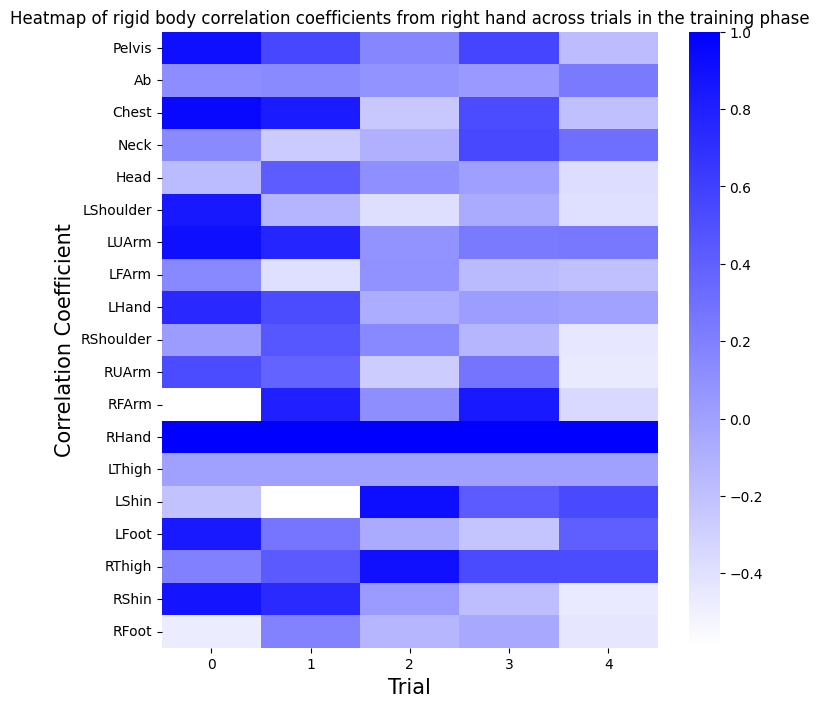

In [4]:
# Set parameters
trials = 5
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1)

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2)

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3)

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4)

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from right hand across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.7987006082378353, and in PC2: 0.09322275622774041
Rigid Body: Ab, variance explained in PC1: 0.7244352081963709, and in PC2: 0.12597427693783378
Rigid Body: Chest, variance explained in PC1: 0.4737622824673479, and in PC2: 0.431002263070605
Rigid Body: Neck, variance explained in PC1: 0.7420383850967887, and in PC2: 0.17405731520039391
Rigid Body: Head, variance explained in PC1: 0.6041235433012764, and in PC2: 0.33221131238816487
Rigid Body: LShoulder, variance explained in PC1: 0.5516892654750751, and in PC2: 0.27981146201867574
Rigid Body: LUArm, variance explained in PC1: 0.7237629130496404, and in PC2: 0.181648582693399
Rigid Body: LFArm, variance explained in PC1: 0.7311882335228711, and in PC2: 0.16914889480386788
Rigid Body: LHand, variance explained in PC1: 0.6235832480816963, and in PC2: 0.2816841084331171
Rigid Body: RShoulder, variance explained in PC1: 0.5383983358691796, and in PC2: 0.26539663338861236
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2197401669.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

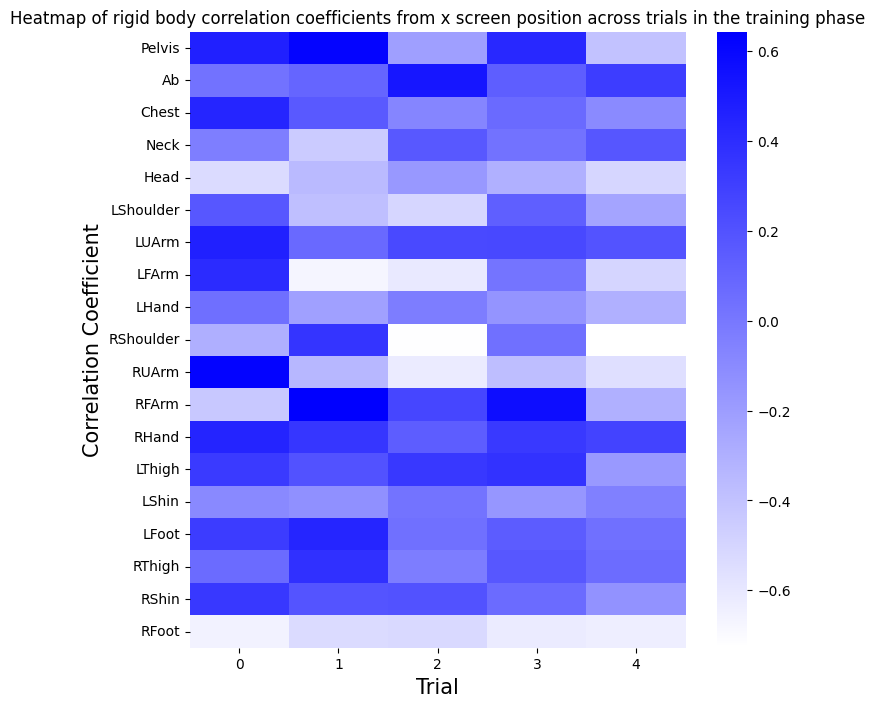

In [5]:
# Set parameters
trials = 5
rigidBodies = 19

# ASSESS CORRELATION TO X


# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4,useCursor = 'x')

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5,useCursor = 'x')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from x screen position across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.7987006082378353, and in PC2: 0.09322275622774046
Rigid Body: Ab, variance explained in PC1: 0.7244352081963704, and in PC2: 0.1259742769378337
Rigid Body: Chest, variance explained in PC1: 0.4737622824673481, and in PC2: 0.4310022630706048
Rigid Body: Neck, variance explained in PC1: 0.742038385096788, and in PC2: 0.17405731520039391
Rigid Body: Head, variance explained in PC1: 0.6041235433012766, and in PC2: 0.3322113123881646
Rigid Body: LShoulder, variance explained in PC1: 0.5516892654750756, and in PC2: 0.2798114620186761
Rigid Body: LUArm, variance explained in PC1: 0.7237629130496392, and in PC2: 0.18164858269339865
Rigid Body: LFArm, variance explained in PC1: 0.7311882335228711, and in PC2: 0.16914889480386777
Rigid Body: LHand, variance explained in PC1: 0.6235832480816967, and in PC2: 0.2816841084331169
Rigid Body: RShoulder, variance explained in PC1: 0.53839833586918, and in PC2: 0.26539663338861225
Rigid Body: RUArm, varia

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/2676363177.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

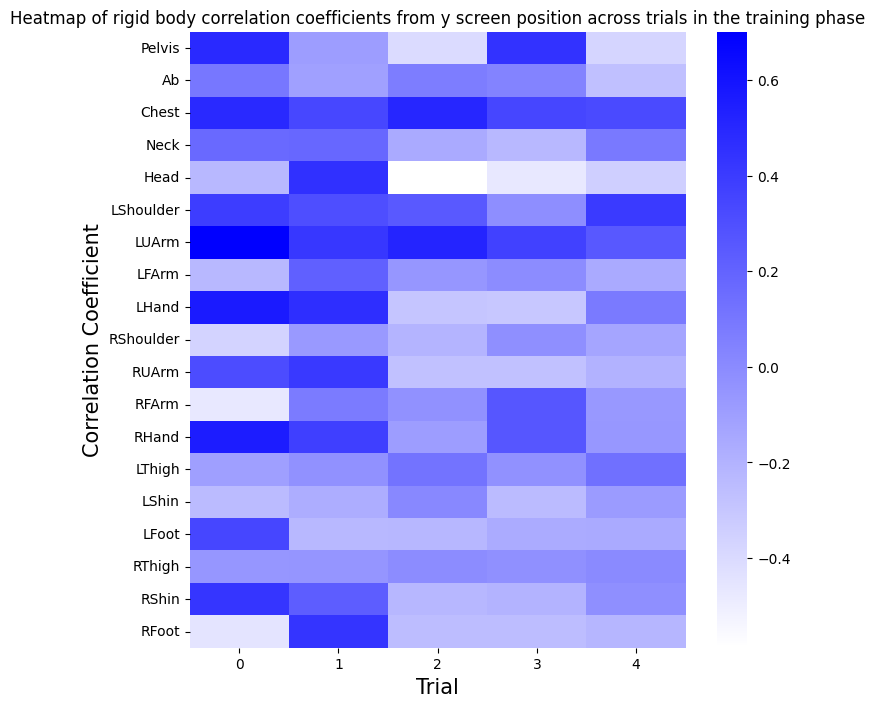

In [6]:
# Set parameters
trials = 5
rigidBodies = 19

# ASSESS CORRELATION TO X


# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4,useCursor = 'y')

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5,useCursor = 'y')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients from y screen position across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coefficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.9667548030895963, and in PC2: 0.03247793278025005
Rigid Body: Ab, variance explained in PC1: 0.6646817393017973, and in PC2: 0.33385380595397773
Rigid Body: Chest, variance explained in PC1: 0.9343454395174824, and in PC2: 0.0465185779293351
Rigid Body: Neck, variance explained in PC1: 0.9715990985521272, and in PC2: 0.027785604726834397
Rigid Body: Head, variance explained in PC1: 0.874104038735731, and in PC2: 0.12495781923054075
Rigid Body: LShoulder, variance explained in PC1: 0.9079399227121648, and in PC2: 0.07958144095267493
Rigid Body: LUArm, variance explained in PC1: 0.8873231934340061, and in PC2: 0.11109903674347284
Rigid Body: LFArm, variance explained in PC1: 0.7602354272223213, and in PC2: 0.23456520833545605
Rigid Body: LHand, variance explained in PC1: 0.7419726718880513, and in PC2: 0.25112503262097335
Rigid Body: RShoulder, variance explained in PC1: 0.6174920679856025, and in PC2: 0.36936120855400995
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

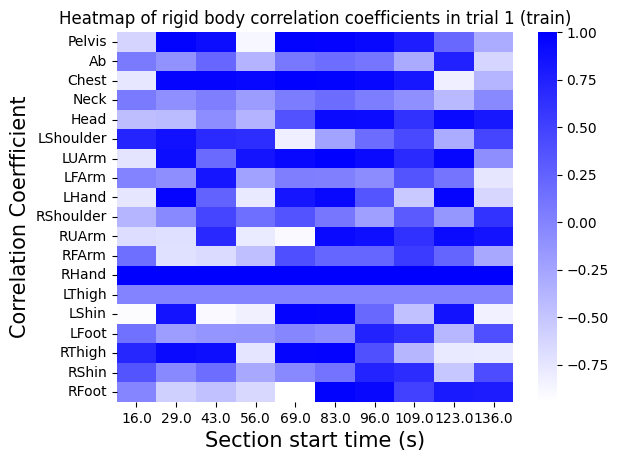

Rigid Body: Pelvis, variance explained in PC1: 0.8551255082533638, and in PC2: 0.10769494740322866
Rigid Body: Ab, variance explained in PC1: 0.6040743529434858, and in PC2: 0.35913474263274126
Rigid Body: Chest, variance explained in PC1: 0.8438883843633455, and in PC2: 0.10394816745764726
Rigid Body: Neck, variance explained in PC1: 0.8220408552096209, and in PC2: 0.12977541387015448
Rigid Body: Head, variance explained in PC1: 0.8046198526919395, and in PC2: 0.11034162651292888
Rigid Body: LShoulder, variance explained in PC1: 0.6693452100382266, and in PC2: 0.258598251129545
Rigid Body: LUArm, variance explained in PC1: 0.8943553217180324, and in PC2: 0.0538967420449758
Rigid Body: LFArm, variance explained in PC1: 0.6828055996242592, and in PC2: 0.20375947654150361
Rigid Body: LHand, variance explained in PC1: 0.5787739980642683, and in PC2: 0.33811012875987917
Rigid Body: RShoulder, variance explained in PC1: 0.788102708987867, and in PC2: 0.12344369063504675
Rigid Body: RUArm, v

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

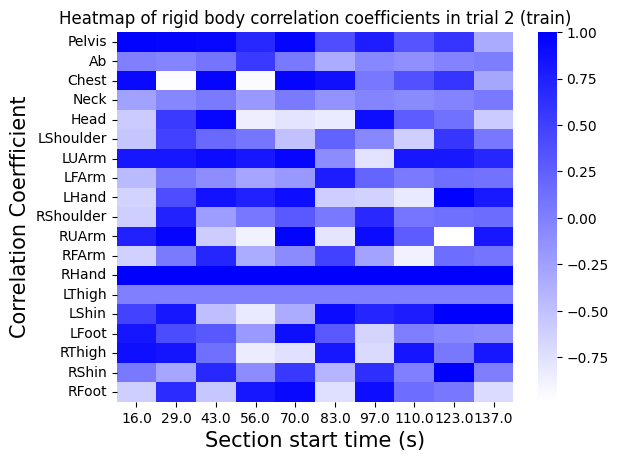

Rigid Body: Pelvis, variance explained in PC1: 0.7648401493357436, and in PC2: 0.22158598530514342
Rigid Body: Ab, variance explained in PC1: 0.853503377194924, and in PC2: 0.13744964153334166
Rigid Body: Chest, variance explained in PC1: 0.8020502074734271, and in PC2: 0.17108434080208373
Rigid Body: Neck, variance explained in PC1: 0.9294427859896851, and in PC2: 0.05918950550293102
Rigid Body: Head, variance explained in PC1: 0.9103578805601509, and in PC2: 0.0720106453627702
Rigid Body: LShoulder, variance explained in PC1: 0.7720263613884659, and in PC2: 0.15649968192558072
Rigid Body: LUArm, variance explained in PC1: 0.8896281228739972, and in PC2: 0.07493491053173423
Rigid Body: LFArm, variance explained in PC1: 0.6771560489165113, and in PC2: 0.20769992913768168
Rigid Body: LHand, variance explained in PC1: 0.7241843600859333, and in PC2: 0.17955479587741285
Rigid Body: RShoulder, variance explained in PC1: 0.8625732136540272, and in PC2: 0.09680440473402523
Rigid Body: RUArm,

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

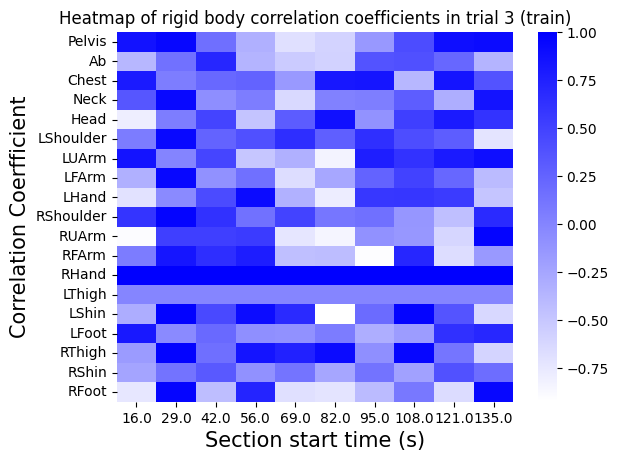

Rigid Body: Pelvis, variance explained in PC1: 0.828239685914395, and in PC2: 0.14565928645168802
Rigid Body: Ab, variance explained in PC1: 0.8145141353939173, and in PC2: 0.11530582251620623
Rigid Body: Chest, variance explained in PC1: 0.7396476074461447, and in PC2: 0.13267013717883297
Rigid Body: Neck, variance explained in PC1: 0.8235835702730776, and in PC2: 0.11962447872546993
Rigid Body: Head, variance explained in PC1: 0.7961306504301453, and in PC2: 0.139945579661742
Rigid Body: LShoulder, variance explained in PC1: 0.7274178917777029, and in PC2: 0.12614492333331015
Rigid Body: LUArm, variance explained in PC1: 0.6750449687765053, and in PC2: 0.18026402039610293
Rigid Body: LFArm, variance explained in PC1: 0.46013338721213576, and in PC2: 0.3708859401608066
Rigid Body: LHand, variance explained in PC1: 0.44334519192202565, and in PC2: 0.27069405996585033
Rigid Body: RShoulder, variance explained in PC1: 0.7503415993345731, and in PC2: 0.14384642063143496
Rigid Body: RUArm,

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

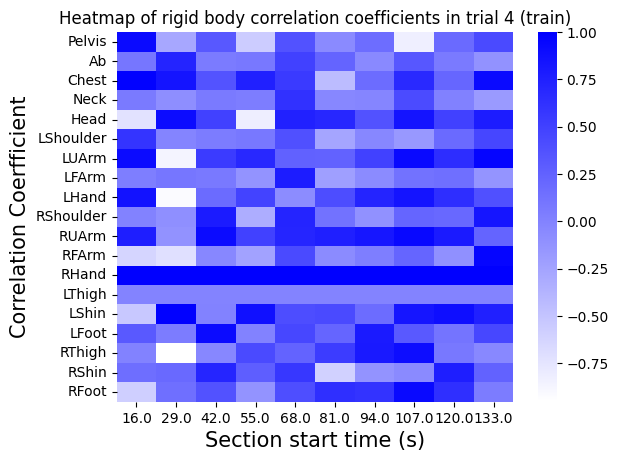

Rigid Body: Pelvis, variance explained in PC1: 0.8886102676998833, and in PC2: 0.09866125506305877
Rigid Body: Ab, variance explained in PC1: 0.821024340431592, and in PC2: 0.16439488842858888
Rigid Body: Chest, variance explained in PC1: 0.7010757309800584, and in PC2: 0.2730840591519696
Rigid Body: Neck, variance explained in PC1: 0.9267772326377044, and in PC2: 0.06641032191700653
Rigid Body: Head, variance explained in PC1: 0.7816651943445978, and in PC2: 0.1987608563549537
Rigid Body: LShoulder, variance explained in PC1: 0.7341095605275729, and in PC2: 0.23943271728325605
Rigid Body: LUArm, variance explained in PC1: 0.8766315846768883, and in PC2: 0.1132466270749602
Rigid Body: LFArm, variance explained in PC1: 0.7695918870547258, and in PC2: 0.21253301574399544
Rigid Body: LHand, variance explained in PC1: 0.8338655841382502, and in PC2: 0.14208870497621548
Rigid Body: RShoulder, variance explained in PC1: 0.863672230581719, and in PC2: 0.10807496023858319
Rigid Body: RUArm, va

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/305315710.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + 

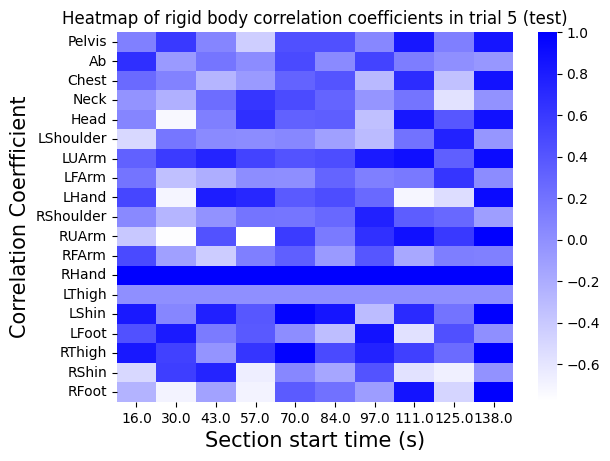

In [7]:
# Plot the correlation over a trial

plotCorrelationCoefficientVariationAcrossTrial(rigidBodies1,cursorPos1,trial = "1 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies2,cursorPos2,trial = "2 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies3,cursorPos3,trial = "3 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies4,cursorPos4,trial = "4 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies5,cursorPos5,trial = "5 (test)")
plt.show()

In [8]:
# Now look at learning over the decoder period



rigidBodiesE, cursorPosE,cursorVelE,goCuesE,targetHitsE,timeStampsE, minDofE,maxDofE,e,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderE",DOFOffset)
rigidBodiesF, cursorPosF,cursorVelF,goCuesF,targetHitsF,timeStampsF, minDofF,maxDofF,f,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderF",DOFOffset)
rigidBodiesG, cursorPosG,cursorVelG,goCuesG,targetHitsG,timeStampsG, minDofG,maxDofG,g,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderG",DOFOffset)
rigidBodiesH, cursorPosH,cursorVelH,goCuesH,targetHitsH,timeStampsH, minDofH,maxDofH,h,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderH",DOFOffset)
rigidBodiesI, cursorPosI,cursorVelI,goCuesI,targetHitsI,timeStampsI, minDofI,maxDofI,i,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderI",DOFOffset)
rigidBodiesJ, cursorPosJ,cursorVelJ,goCuesJ,targetHitsJ,timeStampsJ, minDofJ,maxDofJ,j,targetFailedAppearTimesE = processTrialData(saveGameLocation + "_usingDecoderJ",DOFOffset)

/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis
/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis


Rigid Body: Pelvis, variance explained in PC1: 0.7458297522206923, and in PC2: 0.18299386469642934
Rigid Body: Ab, variance explained in PC1: 0.6411087241217733, and in PC2: 0.31798267087188287
Rigid Body: Chest, variance explained in PC1: 0.7408942030703122, and in PC2: 0.18522198724206068
Rigid Body: Neck, variance explained in PC1: 0.7573215938062501, and in PC2: 0.21200846769764012
Rigid Body: Head, variance explained in PC1: 0.7618536887730137, and in PC2: 0.18800153216721338
Rigid Body: LShoulder, variance explained in PC1: 0.7294324080815381, and in PC2: 0.17933545760245032
Rigid Body: LUArm, variance explained in PC1: 0.7020488419872727, and in PC2: 0.19896751649606112
Rigid Body: LFArm, variance explained in PC1: 0.6595498495983063, and in PC2: 0.26633325895366167
Rigid Body: LHand, variance explained in PC1: 0.7185406472973597, and in PC2: 0.16772202754265872
Rigid Body: RShoulder, variance explained in PC1: 0.837296395600403, and in PC2: 0.09037564629000876
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/416490190.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhas

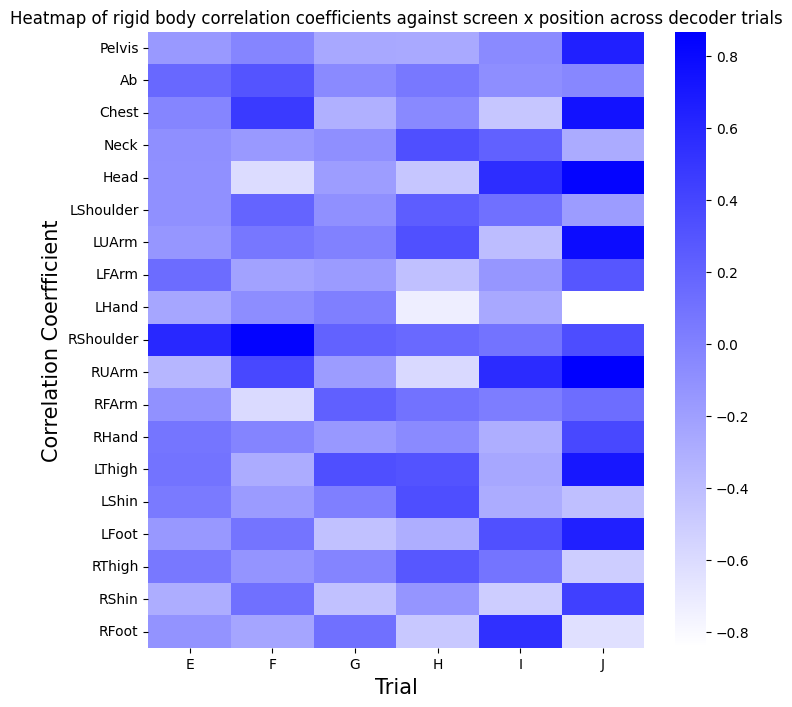

In [9]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = 'x')

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = 'x')

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = 'x')

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = 'x')

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = 'x')

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = 'x')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients against screen x position across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.7458297522206931, and in PC2: 0.1829938646964294
Rigid Body: Ab, variance explained in PC1: 0.6411087241217733, and in PC2: 0.31798267087188287
Rigid Body: Chest, variance explained in PC1: 0.7408942030703122, and in PC2: 0.18522198724206065
Rigid Body: Neck, variance explained in PC1: 0.7573215938062497, and in PC2: 0.21200846769763987
Rigid Body: Head, variance explained in PC1: 0.7618536887730135, and in PC2: 0.18800153216721321
Rigid Body: LShoulder, variance explained in PC1: 0.7294324080815374, and in PC2: 0.1793354576024506
Rigid Body: LUArm, variance explained in PC1: 0.7020488419872732, and in PC2: 0.19896751649606145
Rigid Body: LFArm, variance explained in PC1: 0.6595498495983063, and in PC2: 0.2663332589536622
Rigid Body: LHand, variance explained in PC1: 0.7185406472973599, and in PC2: 0.16772202754265855
Rigid Body: RShoulder, variance explained in PC1: 0.8372963956004024, and in PC2: 0.09037564629000878
Rigid Body: RUArm, 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10293/3647210380.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

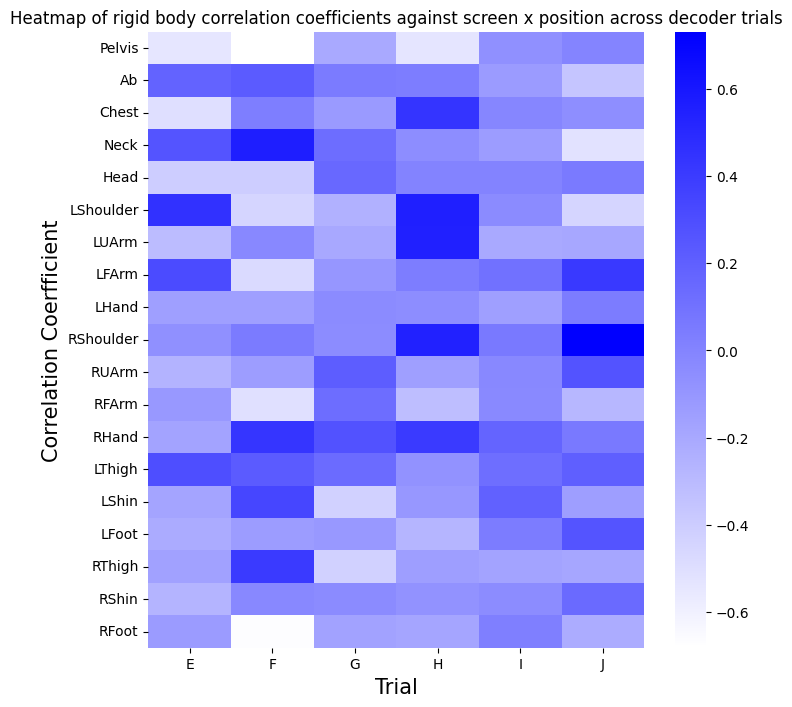

In [10]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = 'y')

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = 'y')

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = 'y')

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = 'y')

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = 'y')

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = 'y')

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients against screen x position across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")